# Data Augmentation and CNN Model Training on ASL Alphabet Data for Gestures Classification
## Importing Dependencies

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))  # Add src/ to sys.path to import modules (e.g. utils)

import string

import torch
from torch.utils.data import DataLoader
from torchinfo import summary

from src.utils.visualization import plot_confusion_matrix, save_figure
from src.utils.model_testing_utils import get_predictions, evaluate_model
from src.transforms.transforms import get_test_transforms, get_grayscale_test_transforms
from src.models.alphabet_gesture_classification_model import ASLAlphabetClassificationModel
from src.datasets.asl_alphabet_dataset import ASLAlphabetDataset

In [2]:
# List of all the letters in the ASL alphabet and other gestures
signs = list(string.ascii_uppercase)
signs.remove("Z") 
signs.append("nothing") 

# Number of signs
num_signs = len(signs)

class_to_idx = {signs[i]: i for i in range(num_signs)}
print(class_to_idx)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'nothing': 25}


In [3]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
model_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "src", "models", "checkpoints"))

In [4]:
model = ASLAlphabetClassificationModel(num_signs, 128, 128)
model.load_state_dict(torch.load(os.path.join(model_dir, "final_model_state_dict.pth"), map_location=torch.device("cpu")))
model.eval()

ASLAlphabetClassificationModel(
  (landmarks_branch): LandmarksBranch(
    (block1): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=63, out_features=128, bias=True)
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (3): ReLU()
    )
    (dropout1): Dropout(p=0.5, inplace=False)
    (block2): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
    )
    (dropout2): Dropout(p=0.5, inplace=False)
    (block3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
    )
  )
  (sign_image_branch): SignImageBranch(
    (conv_block1): MultiScaleBlock(
      (conv1x1): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (conv3x3): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv5x5): 

In [5]:
summary(model, input_size=[(32, 1, 224, 224), (32, 21, 3)], 
        col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ASLAlphabetClassificationModel (ASLAlphabetClassificationModel)   [32, 1, 224, 224]    [32, 26]             --                   True
├─LandmarksBranch (landmarks_branch)                              [32, 21, 3]          [32, 128]            --                   True
│    └─Sequential (block1)                                        [32, 21, 3]          [32, 128]            --                   True
│    │    └─Flatten (0)                                           [32, 21, 3]          [32, 63]             --                   --
│    │    └─Linear (1)                                            [32, 63]             [32, 128]            8,192                True
│    │    └─LayerNorm (2)                                         [32, 128]            [32, 128]            256                  True
│    │    └─ReLU (3)                                       

In [6]:
test_transforms = get_grayscale_test_transforms()

test_dataset = ASLAlphabetDataset(
    data_dir=os.path.join(data_dir, "asl-alphabet-test"),
    landmarks_dir=os.path.join(data_dir, "asl-alphabet-test-landmarks"),
    transforms=test_transforms,
    class_to_idx=class_to_idx,
    rotate_flip=False
)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Confusion Matrix

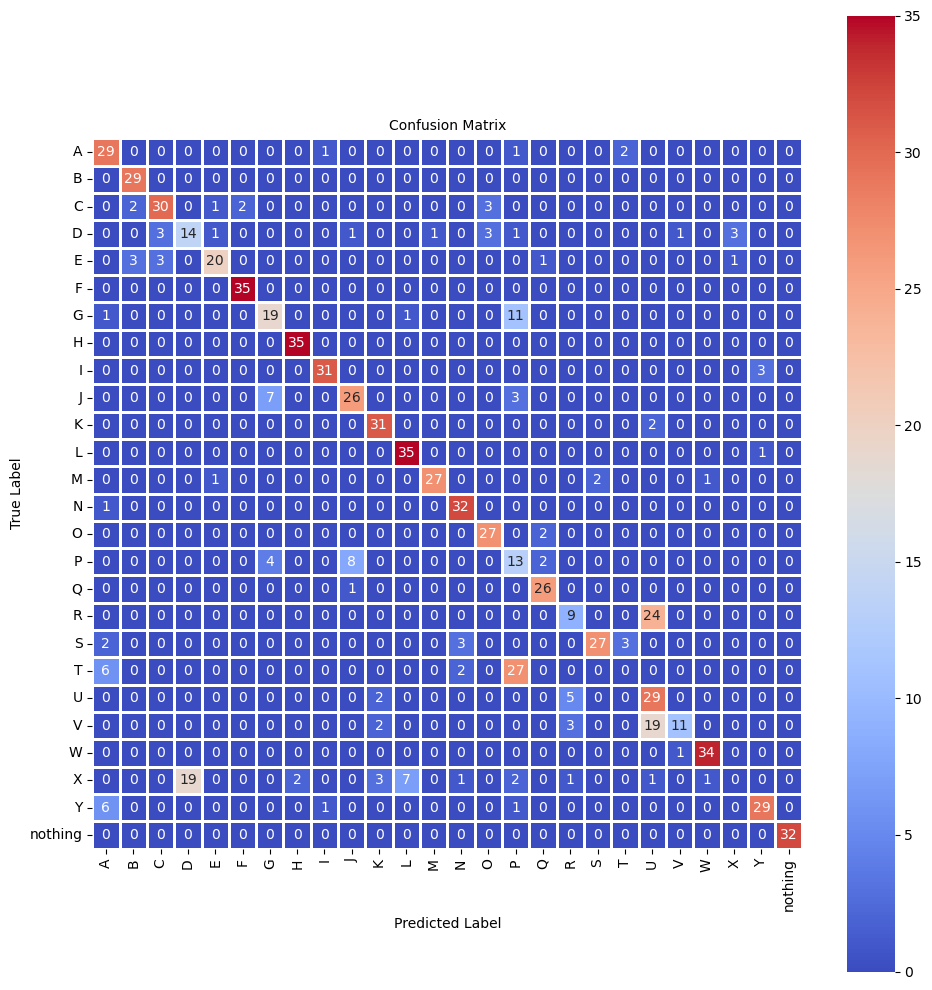

Figure saved ✅


In [7]:
reports_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "reports", "evaluation"))

y_true, y_pred = get_predictions(model, dataloader=test_dataloader)
fig = plot_confusion_matrix(y_true, y_pred, signs)

save_figure(fig, os.path.join(reports_dir, "final_confusion_matrix.png"))

In [8]:
_ = evaluate_model(model, test_dataloader, signs)


🔍 Evaluation Metrics:
Accuracy: 0.7334109429569267
F1 Score (macro): 0.7128075646918774
Precision (macro): 0.7158392199879567
Recall (macro): 0.7368174413480708

Classification Report:
              precision    recall  f1-score   support

           A       0.64      0.88      0.74        33
           B       0.85      1.00      0.92        29
           C       0.83      0.79      0.81        38
           D       0.42      0.50      0.46        28
           E       0.87      0.71      0.78        28
           F       0.95      1.00      0.97        35
           G       0.63      0.59      0.61        32
           H       0.95      1.00      0.97        35
           I       0.94      0.91      0.93        34
           J       0.72      0.72      0.72        36
           K       0.82      0.94      0.87        33
           L       0.81      0.97      0.89        36
           M       0.96      0.87      0.92        31
           N       0.84      0.97      0.90        33
   